**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



In [1]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os
import random
import math

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [4]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [5]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer
def prepareDf(df, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = numDaysInMonth * 60 * day #num seconds in a month of AUGUST
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  

  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [7]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size)

    #############################################train and test #########################################################
    #456 data points 456/24 = 20 days, weekends are excluded (2019)
    #each data point is 24 
    # 80% data = day 0-15 is 16 days -> 360
    # 20% data = day 16-19 is 4 days -> 96

    allIndex = []
    for i in range(0, len(X), window_size): #get the indices for days in the month
      allIndex.append(i)

    random.shuffle(allIndex) #shuffle the indices of the day
    train_size =  round(len(X)/window_size * 0.8)* window_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model, allIndex

In [8]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption
# futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    while(i<howManyFutureHours): #for the next thirty hours
      x_input = np.array(dataForPrediction.iloc[i:window_size+i, :])
      # print("i : ", i)
      # print('x_input: ', x_input)
      # print(x_input.shape)
      x_input = x_input.reshape(1, window_size, numVarInputs)
      yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
      # print('future data: ', yhat[0])
      future_outputs.append(yhat[0][0])
      i=i+1

    return future_outputs

In [9]:
def printMonth_july(date_2019, date_2020, dayInJuly):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season/july/' 
  
  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  
  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)

  result = pd.concat([df2019, df2020], axis=1)
  result['mean'] = result.mean(axis=1)
  # plt.plot(result['mean'], color = 'blue', label = 'average of 2019_2020')

  # plt.xticks(xaxis)
  # plt.xlabel('Hours')
  # plt.ylabel('Megawatts')
  # plt.suptitle(june[dayInJune], weight = 'bold')
  # plt.legend()
  # plt.savefig(pathToSaveData+date_2019+'.jpg', bbox_inches = 'tight', dpi=150)
  # plt.show()
  return result['mean']


# Run

In [10]:
date_2019 = '20190701'
date_2020 = '20200701'
dayInJuly = 0
julyRep = printMonth_july(date_2019, date_2020, dayInJuly)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [21]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

print('-------')
#for now, I will only use SF data 
pos = 3
iteration = 0

fileRead = pathToData + dataFile[pos]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
df_sac = pd.read_csv(pathToData + dataFile[0])
df_sf = pd.read_csv(pathToData + dataFile[1])
df_sd = pd.read_csv(pathToData + dataFile[2])
df_la = pd.read_csv(pathToData + dataFile[3])
# 2021 data
pathToData1 = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/'
dataFile1 = [f for f in listdir(pathToData1) if isfile(join(pathToData1, f))] 
for file in dataFile1:
    print(file)
    # df = pd.read_csv(pathToDir + file)
 
fileRead1 = pathToData1 + dataFile1[pos]
print('fileRead: ', fileRead1)
df2021 = pd.read_csv(fileRead1)
df2021_sac = pd.read_csv(pathToData1 + dataFile1[0])
df2021_sf = pd.read_csv(pathToData1 + dataFile1[1])
df2021_sd = pd.read_csv(pathToData1 + dataFile1[2])
df2021_la = pd.read_csv(pathToData1 + dataFile1[3])

howManyFutureHours = 24
window_size = 72
numEpochs = 20
iters = 1

beg = 4344
end = 5088
numDaysInMonth = 31


baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/'
locArray = ['_SAC', '_SF', '_SD', '_LA']
location = locArray[pos]
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL

SAC-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
-------
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/LA-yearAvg-NOAA-and-Megawatts.csv
SAC-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/LA-NOAA-and-Megawatts.csv


In [22]:
####sac
df_sac.columns[1:-1]
cols_rearranged = list(df_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('AvgMegawatts2019-2020')

df_sac = prepareDf(df_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sac = df_sac[df_sac.is_weekend == 0] # only keeping weekday data
df_sac.drop('is_weekend', axis = 1, inplace =True)
df_sac, allScalers = scaleAllData(df_sac)

#### sf

cols_rearranged_sf = list(df_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df_sf = prepareDf(df_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sf = df_sf[df_sf.is_weekend == 0] # only keeping weekday data
df_sf.drop('is_weekend', axis = 1, inplace =True)

df_sf, discard = scaleAllData(df_sf)

####sd

cols_rearranged_sd = list(df_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df_sd = prepareDf(df_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sd = df_sd[df_sd.is_weekend == 0] # only keeping weekday data
df_sd.drop('is_weekend', axis = 1, inplace =True)

df_sd, discard = scaleAllData(df_sd)

####la

cols_rearranged_la = list(df_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df_la = prepareDf(df_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_la = df_la[df_la.is_weekend == 0] # only keeping weekday data
df_la.drop('is_weekend', axis = 1, inplace =True)

df_la, discard = scaleAllData(df_la)

df = pd.concat([df_sf, df_sd, df_la, df_sac], axis=1) # combine all weather variable data into one dataframe, df
# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers
julyFourth =[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
df.drop(df.index[julyFourth], inplace=True) # remove July 4th

rmse, bestEnergyConsumptionModel, allIndex = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
# rmse, bestEnergyConsumptionModel, X, y = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

########################################## GET DATA FOR FUTURE PREDICTION #######################################################

####sac
df2021_sac.columns[1:-1]
cols_rearranged = list(df2021_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('Megawatts_2021')

df2021_sac = prepareDf(df2021_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sac = df2021_sac[df2021_sac.is_weekend == 0] # only keeping weekday data
df2021_sac.drop('is_weekend', axis = 1, inplace =True)
df2021_sac, discard = scaleAllData(df2021_sac)

#### sf

cols_rearranged_sf = list(df2021_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df2021_sf = prepareDf(df2021_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sf = df2021_sf[df2021_sf.is_weekend == 0] # only keeping weekday data
df2021_sf.drop('is_weekend', axis = 1, inplace =True)

df2021_sf, discard = scaleAllData(df2021_sf)

####sd

cols_rearranged_sd = list(df2021_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df2021_sd = prepareDf(df2021_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sd = df2021_sd[df2021_sd.is_weekend == 0] # only keeping weekday data
df2021_sd.drop('is_weekend', axis = 1, inplace =True)

df2021_sd, discard = scaleAllData(df2021_sd)

####la

cols_rearranged_la = list(df2021_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df2021_la = prepareDf(df2021_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_la = df2021_la[df2021_la.is_weekend == 0] # only keeping weekday data
df2021_la.drop('is_weekend', axis = 1, inplace =True)

df2021_la, discard = scaleAllData(df2021_la)

df2021 = pd.concat([df2021_sf, df2021_sd, df2021_la, df2021_sac], axis=1) # combine all weather variable data into one dataframe, df
df2021.drop(df2021.index[julyFourth], inplace=True) #removing July 4th
# # ########################################## FUTURE PREDICTION #######################################################
numVarInputs = len(df2021.columns)
# lastTwoDays = len(df2021) - 48
df2021_clean = df2021
df2021_clean.drop(df2021_clean.index[julyFourth], inplace=True) #removing July 4th
# df2021 = df2021.iloc[lastTwoDays: , :]
# lst_output = futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
# # # ########################################### check output #######################################################
# megawattsScaler = allScalers[len(allScalers)-1]

# predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
# predicted24Hours = pd.DataFrame(predictedVals)

# print("----------------------------FINAL, DONE;----------------------------")
# rmse = mean_squared_error(juneRep, predicted24Hours, squared=False)
# print('rmse value: ', rmse)

# plt.plot(predicted24Hours, color = 'red', label = 'prediction')
# plt.plot(juneRep, color = 'green', label = 'Average of June_2019, June_2020')
# xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
# plt.xticks(xaxis)
# plt.xlabel('Hours')
# plt.ylabel('Megawatts')
# plt.suptitle('June: rmse: ' + str(rmse))
# plt.legend()
# pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season/all/'
# # plt.savefig(pathToSaveData+'June_randomized_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
# plt.show()

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.0397 - root_mean_squared_error: 0.1993

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 12s 727ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 2/20
12/12 [==============================] - 1s 50ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0722
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0734

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 497ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656
Epoch 4/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0653

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 551ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 5/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0615

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 513ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 6/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0577

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 7s 616ms/step - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 7/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 8/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0575

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 561ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 9/20
12/12 [==============================] - 1s 50ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 10/20
12/12 [==============================] - 1s 51ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 11/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0025 - root_mean_squared_error: 0.0505 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 12/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 507ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 13/20
12/12 [==============================] - 1s 54ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 14/20
12/12 [==============================] - 1s 55ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 15/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 16/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 17/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0447

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/model_LA/assets


12/12 [==============================] - 6s 549ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 8.0812e-04 - val_root_mean_squared_error: 0.0284
Epoch 18/20
12/12 [==============================] - 1s 51ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 19/20
12/12 [==============================] - 1s 50ms/step - loss: 9.3606e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 20/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 8.1225e-04 - val_root_mean_squared_error: 0.0285
RMSE value:  0.027790460968758257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/Best_LA/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/Best_LA/energyModel/assets


In [ ]:
# 360 = day 15 = June 24
# 360 -> predict hour 1
# 361 -> predict hour 2
# 362 -> predict hour 3
# 72 = June 6
# ORIGINAL X LENGTH IS 456
# 0-> June 3
# 1 -> June 3+4
# 2 -> June 3+4
# ...
# 24 -> June 4

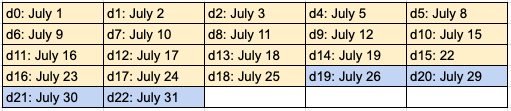

In [28]:
# four days of prediction
allIndex[19-4:]

# for that first index, pass the previous day and itself to predict that day
# four days of prediction
allDays = []
for i in range(0,4):
  print("pos: ", allIndex[i], " d", allIndex[i]/24)
  allDays.append(allIndex[i])

# d1 = allDays[0]
# d2 = allDays[1]
# d3 = allDays[2]
# d4 = allDays[3]
d1 = 288 #day 12
d2 = 96 # day 4 
d3 = 408 #day 17
d4 = 480 # day 20

pos:  144  d 6.0
pos:  72  d 3.0
pos:  288  d 12.0
pos:  360  d 15.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


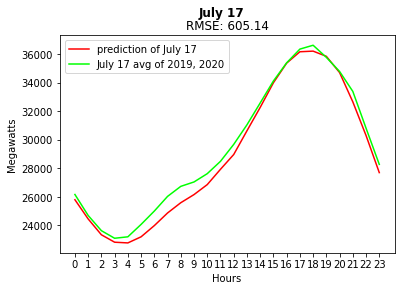

In [24]:
########## DAY 1: D12 = July 17
date_2019 = '20190717'
date_2020 = '20200717'
dayInJuly = 16
julyRep1 = printMonth_july(date_2019, date_2020, dayInJuly)

day1 = df2021_clean.iloc[d1-window_size:d1+window_size,:]
lst_output_1 = futurePredictions_EC(bestEnergyConsumptionModel, day1, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output_1).reshape(-1,1))
predicted24Hours_1 = pd.DataFrame(predictedVals)

rmse_1 = round(mean_squared_error(julyRep1, predicted24Hours_1, squared=False), 2)

plt.plot(predicted24Hours_1, color = 'red', label = 'prediction of July 17')
plt.plot(julyRep1, color = 'lime', label ='July 17 avg of 2019, 2020')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 17', weight='bold')
plt.title("RMSE: " + str(rmse_1))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/all/'
plt.savefig(pathToSaveData+'July_predict17.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


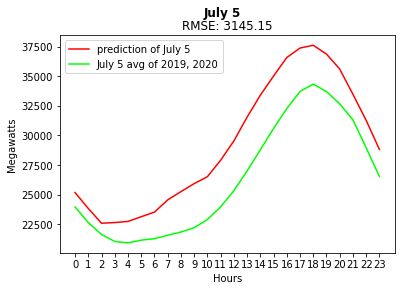

In [25]:
########## DAY 2: D4 = July 5
date_2019 = '20190705'
date_2020 = '20200705'
dayInJuly = 4
julyRep2 = printMonth_july(date_2019, date_2020, dayInJuly)

day2 = df2021_clean.iloc[d2-window_size:d2+window_size,:]
lst_output_2 = futurePredictions_EC(bestEnergyConsumptionModel, day2, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output_2).reshape(-1,1))
predicted24Hours_2 = pd.DataFrame(predictedVals)

rmse_2 = round(mean_squared_error(julyRep2, predicted24Hours_2, squared=False), 2)

plt.plot(predicted24Hours_2, color = 'red', label = 'prediction of July 5')
plt.plot(julyRep2, color = 'lime', label ='July 5 avg of 2019, 2020')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 5', weight='bold')
plt.title("RMSE: " + str(rmse_2))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/all/'
plt.savefig(pathToSaveData+'July_predict5.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


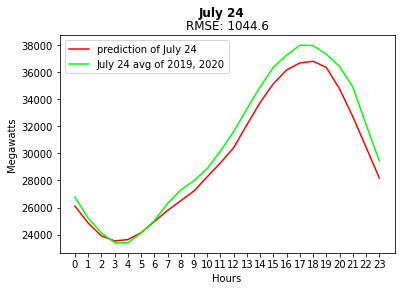

In [26]:
########## DAY 3: D17 = July 24
date_2019 = '20190724'
date_2020 = '20200724'
dayInJuly = 23
julyRep3 = printMonth_july(date_2019, date_2020, dayInJuly)

day3 = df2021_clean.iloc[d3-window_size:d3+window_size,:]
lst_output_3 = futurePredictions_EC(bestEnergyConsumptionModel, day3, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output_3).reshape(-1,1))
predicted24Hours_3 = pd.DataFrame(predictedVals)

rmse_3 = round(mean_squared_error(julyRep3, predicted24Hours_3, squared=False), 2)

plt.plot(predicted24Hours_3, color = 'red', label = 'prediction of July 24')
plt.plot(julyRep3, color = 'lime', label ='July 24 avg of 2019, 2020')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 24', weight='bold')
plt.title("RMSE: " + str(rmse_3))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/all/'
plt.savefig(pathToSaveData+'July_predict24.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


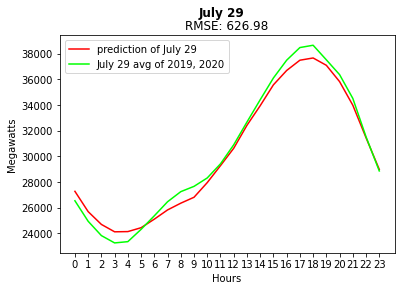

In [27]:
########## DAY 4: D20 = July 29
date_2019 = '20190729'
date_2020 = '20200729'
dayInJuly = 28 #0->june 1, so it is date -1 
julyRep4 = printMonth_july(date_2019, date_2020, dayInJuly)

day4 = df2021_clean.iloc[d4-window_size:d4+window_size,:]
lst_output_4 = futurePredictions_EC(bestEnergyConsumptionModel, day4, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output_4).reshape(-1,1))
predicted24Hours_4 = pd.DataFrame(predictedVals)

rmse_4 = round(mean_squared_error(julyRep4, predicted24Hours_4, squared=False), 2)

plt.plot(predicted24Hours_4, color = 'red', label = 'prediction of July 29')
plt.plot(julyRep4, color = 'lime', label ='July 29 avg of 2019, 2020')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 29', weight='bold')
plt.title("RMSE: " + str(rmse_4))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/all/'
plt.savefig(pathToSaveData+'July_predict29.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

In [ ]:
# reasons for bad performance between the random days
# look at difference between 2019, 2020, and 2021 energy consumption for each of those days
# look at # of bad weather data points and see if that is a factor

In [ ]:
def printDay_july(date_2019, date_2020, date_2021, july_date):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season2/all/' 
  
  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  read2021 = pathToData + beg + date_2021 + end
  
  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)
  df2021 = pd.read_csv(read2021)

  rms2019_2020 += round(mean_squared_error(df2019['Megawatts'], df2020['Megawatts'], squared=False), 2)
  rms2019_2021 += round(mean_squared_error(df2019['Megawatts'], df2021['Megawatts'], squared=False), 2)
  rms2020_2021 += round(mean_squared_error(df2020['Megawatts'], df2021['Megawatts'], squared=False), 2)

  plt.plot(df2019['Megawatts'], color = 'blue', label = '2019')
  plt.plot(df2020['Megawatts'], color = 'red', label = '2020')
  plt.plot(df2021['Megawatts'], color = 'green', label = '2021')
  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  plt.suptitle(july[july_date], weight = "bold")
  plt.title('RMSEs: ' + '2019-2020('+str(rms2019_2020)+') 2019-2021('+str(rms2019_2021)+') 2020-2021('+str(rms2020_2021)+')')
  plt.legend()
  plt.savefig(pathToSaveData+str(july[july_date])+'.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()

  rms2019_2020 += mean_squared_error(df2019['Megawatts'], df2020['Megawatts'], squared=False)
  rms2019_2021 += mean_squared_error(df2019['Megawatts'], df2021['Megawatts'], squared=False)
  rms2020_2021 += mean_squared_error(df2020['Megawatts'], df2021['Megawatts'], squared=False)
    
  avg3 = (rms2019_2020/30 + rms2019_2021/30 + rms2020_2021/30)/3
  # print('Average RMSE between 2019-2020, 2019-2021, 2020-2021: ', avg3)

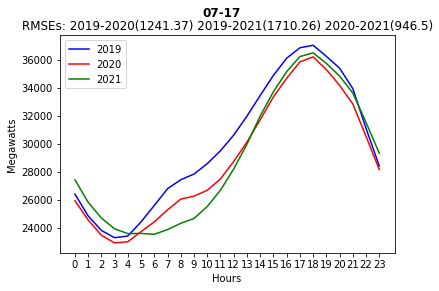

In [ ]:
# date_2019, date_2020, date_2021, june_date
# July 17, July 5, July 24, July 29
date_2019 = "20190717"
date_2020 = "20200717"
date_2021 = "20210717"
july_date = 16
printDay_july(date_2019, date_2020, date_2021, july_date)

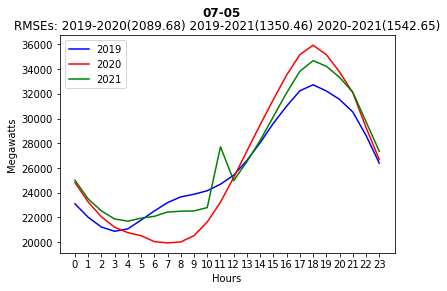

In [ ]:
#july 4
date_2019 = "20190705"
date_2020 = "20200705"
date_2021 = "20210705"
july_date = 4
printDay_july(date_2019, date_2020, date_2021, july_date)

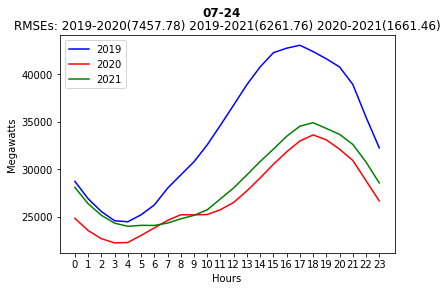

In [ ]:
#july 24
date_2019 = "20190724"
date_2020 = "20200724"
date_2021 = "20210724"
july_date = 23
printDay_july(date_2019, date_2020, date_2021, july_date)

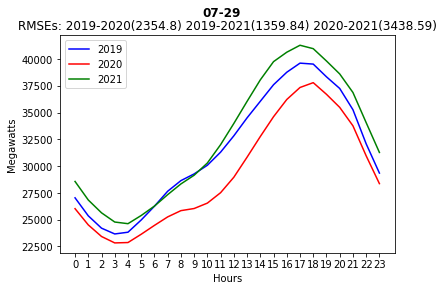

In [ ]:
# july 29
date_2019 = "20190729"
date_2020 = "20200729"
date_2021 = "20210729"
july_date = 28
printDay_july(date_2019, date_2020, date_2021, july_date)